In [52]:
from functools import partial
from itertools import chain

import librosa.effects
import numpy as np
import pandas as pd
import soundfile as sf

import os

from ipywidgets import Audio
from matplotlib import pyplot as plt
from tqdm.contrib.concurrent import process_map
from tqdm.notebook import tqdm

import librosa

In [53]:
INFERENCE_ROOT = "/home/kwatchar3/Documents/data/moisesdb/"
STEM_SETUP = "everything"
GROUND_TRUTH_ROOT = "/home/kwatchar3/Documents/data/moisesdb"

In [54]:
variants = [
    "ev-d-pre",
    "ev-d-prefz",
    "ev-d-pre-aug",
    # "ev-d-pre-bal",
    "ev-d-prefz-bal",
    # "ev-d-pre-aug-bal",
]



In [55]:
gt_files = os.listdir(os.path.join(GROUND_TRUTH_ROOT, "npy2"))

In [56]:
def snr(gt, est):
    return 10 * np.log10(np.sum(np.square(gt)) / np.sum(np.square(gt - est)))

In [57]:
variants = [
    "ev-d-pre",
    "ev-d-prefz",
    "ev-d-pre-gaug",
    # "ev-d-pre-aug",
    "ev-d-pre-bal",
    "ev-d-prefz-bal",
    # "ev-d-pre-bal",
    # "ev-d-pre-aug-bal",
]



In [202]:
allowed_stems = [
      "lead_female_singer",
      "lead_male_singer",
      "background_vocals",
      "drums",
      "bass_guitar",
      "bass_synthesizer",
      "acoustic_guitar",
      "clean_electric_guitar",
      "distorted_electric_guitar",
      "grand_piano",
      "electric_piano",
      "pitched_percussion",
      "organ_electric_organ",
      "string_section",
      "other_strings",
      "brass",
      "reeds",
      "other_wind",
      "synth_pad",
      "synth_lead",
      "other_plucked",
      "fx",
  ]

In [59]:
def get_results_for_song(inputs):

    song_name, inference_mode, variant = inputs

    stems = os.listdir(os.path.join(INFERENCE_ROOT, inference_mode, STEM_SETUP, variant, "audio", song_name))
    stems = [s.replace(".wav", "") for s in stems]

    results = []

    for stem in stems:
        if stem not in allowed_stems:
            continue

        audio_est, sr = sf.read(os.path.join(INFERENCE_ROOT, inference_mode, STEM_SETUP, variant, "audio", song_name, f"{stem}.wav"))
        audio_est = audio_est.T

        npy_path = os.path.join(GROUND_TRUTH_ROOT, "npy2", song_name, f"{stem}.npy")
        if os.path.exists(npy_path):
            audio = np.load(npy_path, mmap_mode="r")
        else:
            print("!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!")
            print(f"Ground truth not found for {song_name}/{stem}. Using zeros.")
            print("!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!")
            audio = np.zeros_like(audio_est)

        snr_full = snr(audio, audio_est)

        target_dbrms = 10 * np.log10(
            np.mean(np.square(audio))
        )

        est_dbrms = 10 * np.log10(
            np.mean(np.square(audio_est))
        )

        results.append({
            "song": song_name,
            "stem": stem,
            "snr": snr_full,
            "target_dbrms": target_dbrms,
            "est_dbrms": est_dbrms,
            "dbdiff": est_dbrms - target_dbrms,
            "variant": variant,
            "inference_mode": inference_mode,
        })

    return results



In [60]:

df = []

for inference_mode in ["inference-d", "inference-o"]:

    for v in variants:
        print(f"Processing {v}...")

        test_files = os.listdir(os.path.join(INFERENCE_ROOT, inference_mode, STEM_SETUP, v, "audio"))

        # for song in tqdm(test_files):
        #     results = get_results_for_song(song, inference_mode, v)
        #     df.extend(results)

        inputs = [(song, inference_mode, v) for song in test_files]

        results = process_map(get_results_for_song, inputs, max_workers=16)
        results = list(chain(*results))

        df.extend(results)


df = pd.DataFrame(df)

Processing ev-d-pre...


  0%|          | 0/48 [00:00<?, ?it/s]

Processing ev-d-prefz...


  0%|          | 0/48 [00:00<?, ?it/s]

Processing ev-d-pre-gaug...


  0%|          | 0/48 [00:00<?, ?it/s]

Processing ev-d-pre-bal...


  0%|          | 0/48 [00:00<?, ?it/s]

Processing ev-d-prefz-bal...


  0%|          | 0/48 [00:00<?, ?it/s]

Processing ev-d-pre...


  0%|          | 0/48 [00:00<?, ?it/s]

Processing ev-d-prefz...


  0%|          | 0/48 [00:00<?, ?it/s]

Processing ev-d-pre-gaug...


  0%|          | 0/48 [00:00<?, ?it/s]

Processing ev-d-pre-bal...


  0%|          | 0/48 [00:00<?, ?it/s]

Processing ev-d-prefz-bal...


  0%|          | 0/48 [00:00<?, ?it/s]

In [61]:
df

,song,stem,snr,target_dbrms,est_dbrms,dbdiff,variant,inference_mode
0,704f1de9-1d02-4c2b-af05-107a7700a51d,bass_guitar,8.722601,-26.048121,-26.535334,-0.487212,ev-d-pre,inference-d
1,704f1de9-1d02-4c2b-af05-107a7700a51d,drums,11.773505,-26.920614,-27.213932,-0.293317,ev-d-pre,inference-d
2,704f1de9-1d02-4c2b-af05-107a7700a51d,acoustic_guitar,1.481413,-34.269612,-38.385900,-4.116288,ev-d-pre,inference-d
3,704f1de9-1d02-4c2b-af05-107a7700a51d,lead_male_singer,7.242387,-33.209226,-33.590568,-0.381341,ev-d-pre,inference-d
4,704f1de9-1d02-4c2b-af05-107a7700a51d,background_vocals,2.027336,-39.184458,-42.853760,-3.669302,ev-d-pre,inference-d
...,...,...,...,...,...,...,...,...
3005,1f98fe4d-26c7-460f-9f68-33964bc4d8d3,distorted_electric_guitar,3.586968,-34.654398,-37.656161,-3.001763,ev-d-prefz-bal,inference-o
3006,1f98fe4d-26c7-460f-9f68-33964bc4d8d3,bass_guitar,8.265368,-35.536811,-35.707326,-0.170515,ev-d-prefz-bal,inference-o
3007,1f98fe4d-26c7-460f-9f68-33964bc4d8d3,drums,10.185577,-32.542546,-33.214525,-0.671979,ev-d-prefz-bal,inference-o
3008,1f98fe4d-26c7-460f-9f68-33964bc4d8d3,lead_male_singer,0.828639,-40.648432,-39.721159,0.927273,ev-d-prefz-bal,inference-o


In [62]:
df["snr"] = df["snr"].replace(-np.inf, np.nan)

In [149]:
df.to_csv(os.path.join(INFERENCE_ROOT, "bandit_ev.csv"), index=False)

In [274]:
short_stems = {
    "lead_female_singer": "Female Vox",
     'lead_male_singer': "Male Vox",
     'drums': "Drums",
     'bass_guitar': "Bass Gtr.",
     'acoustic_guitar': "Acoustic Gtr.",
     'clean_electric_guitar': "Clean E. Gtr.",
     'distorted_electric_guitar': "Distorted E. Gtr.",
     'grand_piano': "Grand Piano",
     'electric_piano': "E. Piano",
     'pitched_percussion': "Pitched Perc.",
     'organ_electric_organ': "Organ & E. Organ",
     'string_section': "String Section",
     'other_strings': "O. Str.",
     'brass': "Brass",
     'reeds': "Reeds",
     'other_wind': "O. Wind",
     'synth_pad': "Synth Pad",
     'synth_lead': "Synth Lead",
     'other_plucked': "O Pluck",
     'background_vocals': "Background Vox",
     'bass_synthesizer': "Bass Synth",
     'fx': "Fx.",
}

In [307]:
df = pd.read_csv(os.path.join(INFERENCE_ROOT, "bandit_ev.csv"))

stem_dtype = pd.CategoricalDtype(categories=allowed_stems, ordered=True)
df["stem"] = df["stem"].astype(stem_dtype)

bool_dtype = pd.CategoricalDtype(categories=["Y", "N"], ordered=True)
ibool_dtype = pd.CategoricalDtype(categories=["N", "Y"], ordered=True)

df["is_frozen"] = df["variant"].str.contains("prefz").apply(lambda x: "Y" if x else "N").astype(bool_dtype)
df["is_balanced"] = df["variant"].str.contains("bal").apply(lambda x: "Y" if x else "N").astype(ibool_dtype)
df["is_augmented"] = df["variant"].str.contains("aug").apply(lambda x: "Y" if x else "N").astype(ibool_dtype)
df["query_same"] = df["inference_mode"].str.contains("-o").apply(lambda x: "same" if x else "diff.")

scount = df["stem"].value_counts()

In [204]:
import seaborn as sns

In [308]:
def clean_variant(s):

    out = []

    if "fz" in s:
        out.append("FE")
    else:
        out.append("TE")

    if "aug" in s:
        out.append("DA")

    if "bal" in s:
        out.append("BS")

    return "+".join(out)

observed_stems = [
    s for s in scount.index if scount[s] > 0
]

observed_stems = [s for s in allowed_stems if s in observed_stems]

observed_stems_dtype = pd.CategoricalDtype(categories=observed_stems, ordered=True)

df["stem"] = df["stem"].astype(observed_stems_dtype)
df["short_stem"] = df["stem"].map(short_stems)
df["variant"] = df["variant"].apply(clean_variant)

variants = sorted(df["variant"].unique().tolist())
variants_dtype = pd.CategoricalDtype(categories=variants, ordered=True)
df["variant"] = df["variant"].astype(variants_dtype)

# df = df[df["query_same"] == "diff."]
df = df[df["query_same"] == "same"]


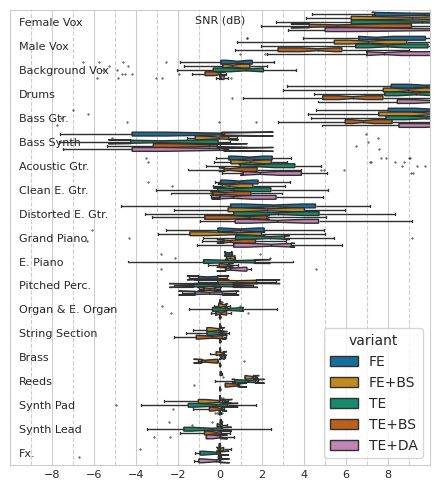

In [311]:
f, ax = plt.subplots(1, 1, figsize=(4.5, 5))

sns.boxplot(data=df,
            y="short_stem",
            x="snr",
            hue="variant",
            palette="colorblind",
            notch=True,
            showfliers=True,
            fliersize=1,
            flierprops=dict(marker='.'),
            ax=ax,
            )


ax.set_xlabel("SNR (dB)", fontsize=8, labelpad=-10)
ax.set_ylabel("")
ax.tick_params(axis='y', labelsize=8, pad=-10)
ax.tick_params(axis='x', labelsize=8, pad=0)
ax.xaxis.set_label_position('top')

major_xtick = np.arange(-8, 8.1, 2)
ax.set_xticks(major_xtick)

minor_xtick = np.arange(-10, 10, 1)
ax.set_xticks(minor_xtick, minor=True)

ax.grid(which='minor', axis='x', linestyle='--')

for label in ax.get_yticklabels():
    label.set_fontsize(8)
    label.set_horizontalalignment('left')

plt.tight_layout()

ax.set(xlim=(-10, 10))

plt.savefig("bandit_ev_snr_same.pdf")

plt.show()


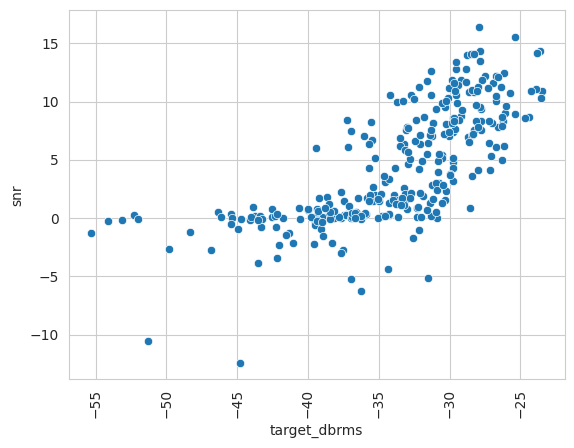

In [322]:
sns.scatterplot(
    df[df.variant == "FE+BS"],
    y="snr",
    x="target_dbrms",
)

# rotate x-axis labels
plt.xticks(rotation=90)

plt.show()

In [329]:
kendall_tau = df.groupby(["variant"]).apply(lambda x: x["snr"].corr(x["target_dbrms"], method="spearman"))

kendall_tau.sort_index()

/tmp/ipykernel_1544437/3885472021.py:1: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  kendall_tau = df.groupby(["variant"]).apply(lambda x: x["snr"].corr(x["target_dbrms"], method="spearman"))


variant
FE       0.795029
FE+BS    0.813281
TE       0.795789
TE+BS    0.812633
TE+DA    0.780357
dtype: float64

In [191]:
extra_stems = [
 'background_vocals',
 'bass_synthesizer',
 'pitched_percussion',
 'organ_electric_organ',
 'string_section',
 # 'other_strings',
 'brass',
 'reeds',
 # 'other_wind',
 'synth_pad',
 'synth_lead',
 # 'other_plucked',
 'fx'
]

extra_stems1 = [
 'background_vocals',
 'bass_synthesizer',
 'pitched_percussion',
 'organ_electric_organ',
 'string_section',
]

extra_stems2 = [
 'brass',
 'reeds',
 'synth_pad',
 'synth_lead',
    'fx',
 # 'other_strings',
 # 'other_wind',
 # 'other_plucked',
]

old_stems = [s for s in allowed_stems if s not in extra_stems]

extra_stems1_dtype = pd.CategoricalDtype(categories=extra_stems1, ordered=True)
extra_stems2_dtype = pd.CategoricalDtype(categories=extra_stems2, ordered=True)


In [170]:
def q25(x):
    return x.quantile(0.25)

def q75(x):
    return x.quantile(0.75)

def q50(x):
    return x.quantile(0.5)

dfagg = df.groupby([
    "is_frozen",
    "is_augmented",
    "is_balanced",
    "query_same",
    "stem"
]).agg({"snr": [q25, q50, q75]})

dfagg_ = df.groupby([
    "is_frozen",
    "is_augmented",
    "is_balanced",
    "query_same",
    "stem"
]).agg({"dbdiff": [q50]})

dfagg.columns = ["q25", "q50", "q75"]
dfagg = dfagg.reset_index()

dfagg_.columns = ["dbdiff"]
dfagg_ = dfagg_.reset_index()

dfagg = dfagg.merge(dfagg_, on=["is_frozen", "is_augmented", "is_balanced", "query_same", "stem"])





/tmp/ipykernel_1544437/1112056648.py:10: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  dfagg = df.groupby([
/tmp/ipykernel_1544437/1112056648.py:18: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  dfagg_ = df.groupby([


In [171]:
dfagg["stem"].unique().tolist()

['lead_female_singer',
 'lead_male_singer',
 'drums',
 'bass_guitar',
 'acoustic_guitar',
 'clean_electric_guitar',
 'distorted_electric_guitar',
 'grand_piano',
 'electric_piano',
 'pitched_percussion',
 'organ_electric_organ',
 'string_section',
 'other_strings',
 'brass',
 'reeds',
 'other_wind',
 'synth_pad',
 'synth_lead',
 'other_plucked',
 'background_vocals',
 'bass_synthesizer',
 'fx']

In [172]:
def df_to_string(dfagg):
    dfagg["stem"] = dfagg["stem"].map(short_stems)

    dfagg = dfagg[dfagg["query_same"] == "same"]

    dfagg = dfagg.reset_index().pivot_table(
        index=["is_frozen", "is_augmented", "is_balanced"],
        columns="stem",
        values=["q25", "q50", "q75", "dbdiff"]
    )

    dfagg = dfagg.swaplevel(axis=1).sort_index(axis=1)
    dfagg_max = dfagg.max(axis=0)


    def bold_formatter(x, val):
        if round(x, 1) == round(val, 1):
            return r"\bfseries " + f"{x:.1f}"
        return f"{x:.1f}"

    formatters = {
        (c, d): partial(bold_formatter, val=dfagg_max.loc[c, d])
        for c, d in dfagg.columns
    }

    str_ = dfagg.to_latex(
        formatters=formatters,
        sparsify=True,
        multirow=False,
    ).replace("_", " ")

    return str_, dfagg


In [173]:
dfagg1 = dfagg[dfagg["stem"].isin(extra_stems1)]
dfagg2 = dfagg[dfagg["stem"].isin(extra_stems2)]

dfaggb = dfagg[dfagg["stem"].isin(old_stems)]

dfagg1["stem"] = dfagg1["stem"].astype(extra_stems1_dtype)
dfagg2["stem"] = dfagg2["stem"].astype(extra_stems2_dtype)
dfaggb["stem"] = dfaggb["stem"].astype(stem_dtype)


str1, dfagg1 = df_to_string(dfagg1)
str2, dfagg2 = df_to_string(dfagg2)

str3, dfaggb = df_to_string(dfaggb)

str_all, dfagg_all = df_to_string(dfagg)

/tmp/ipykernel_1544437/2659099969.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfagg1["stem"] = dfagg1["stem"].astype(extra_stems1_dtype)
/tmp/ipykernel_1544437/2659099969.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfagg2["stem"] = dfagg2["stem"].astype(extra_stems2_dtype)
/tmp/ipykernel_1544437/2659099969.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentat

In [174]:
print(str1)

\begin{tabular}{lllrrrrrrrrrrrrrrrrrrrr}
\toprule
 &  & stem & \multicolumn{4}{r}{Bg Vox} & \multicolumn{4}{r}{B Synth} & \multicolumn{4}{r}{P Perc} & \multicolumn{4}{r}{Org} & \multicolumn{4}{r}{Str Sec} \\
 &  &  & dbdiff & q25 & q50 & q75 & dbdiff & q25 & q50 & q75 & dbdiff & q25 & q50 & q75 & dbdiff & q25 & q50 & q75 & dbdiff & q25 & q50 & q75 \\
is frozen & is augmented & is balanced &  &  &  &  &  &  &  &  &  &  &  &  &  &  &  &  &  &  &  &  \\
\midrule
Y & N & N & -4.9 & 0.0 & 0.8 & 1.5 & \bfseries 0.3 & -4.2 & \bfseries -0.0 & 0.1 & -8.7 & -1.0 & -0.6 & -0.1 & -47.3 & \bfseries 0.0 & 0.0 & 0.0 & -52.4 & \bfseries -0.0 & \bfseries 0.0 & 0.0 \\
 &  & Y & -5.2 & \bfseries 0.1 & 0.6 & 1.4 & -1.0 & \bfseries -1.2 & -0.1 & \bfseries 0.4 & \bfseries -2.7 & \bfseries -0.1 & \bfseries 0.8 & \bfseries 1.7 & -9.2 & -0.1 & 0.2 & 0.3 & -9.3 & -0.6 & -0.1 & -0.0 \\
N & N & N & \bfseries -3.1 & -0.3 & \bfseries 1.2 & \bfseries 2.1 & 0.1 & -4.2 & -2.8 & -0.1 & -2.9 & -1.3 & -0.3 & 0.6 & \bfser

In [175]:


print(str2)

\begin{tabular}{lllrrrrrrrrrrrrrrrrrrrr}
\toprule
 &  & stem & \multicolumn{4}{r}{Brass} & \multicolumn{4}{r}{Reeds} & \multicolumn{4}{r}{Pad} & \multicolumn{4}{r}{Lead} & \multicolumn{4}{r}{Fx} \\
 &  &  & dbdiff & q25 & q50 & q75 & dbdiff & q25 & q50 & q75 & dbdiff & q25 & q50 & q75 & dbdiff & q25 & q50 & q75 & dbdiff & q25 & q50 & q75 \\
is frozen & is augmented & is balanced &  &  &  &  &  &  &  &  &  &  &  &  &  &  &  &  &  &  &  &  \\
\midrule
Y & N & N & -33.5 & 0.0 & 0.0 & 0.0 & -29.3 & 0.0 & 0.0 & 0.1 & -45.4 & \bfseries 0.0 & \bfseries 0.0 & 0.0 & -18.3 & \bfseries 0.0 & \bfseries 0.1 & \bfseries 0.1 & -27.7 & \bfseries -0.0 & \bfseries -0.0 & -0.0 \\
 &  & Y & -11.9 & -0.2 & \bfseries 0.1 & \bfseries 0.2 & \bfseries -5.5 & \bfseries 1.2 & \bfseries 1.5 & 1.6 & -6.0 & -1.0 & -0.1 & 0.1 & -13.0 & -0.1 & -0.0 & \bfseries 0.1 & \bfseries -15.3 & -0.1 & \bfseries 0.0 & \bfseries 0.2 \\
N & N & N & -14.7 & \bfseries 0.1 & \bfseries 0.1 & \bfseries 0.2 & -7.9 & 0.7 & 1.3 & \bfserie

In [176]:


print(str3)

\begin{tabular}{lllrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrr}
\toprule
 &  & stem & \multicolumn{4}{r}{F Vox} & \multicolumn{4}{r}{M Vox} & \multicolumn{4}{r}{Dr} & \multicolumn{4}{r}{B Gtr} & \multicolumn{4}{r}{A Gtr} & \multicolumn{4}{r}{C E Gtr} & \multicolumn{4}{r}{D E Gtr} & \multicolumn{4}{r}{G Pno} & \multicolumn{4}{r}{E Pno} \\
 &  &  & dbdiff & q25 & q50 & q75 & dbdiff & q25 & q50 & q75 & dbdiff & q25 & q50 & q75 & dbdiff & q25 & q50 & q75 & dbdiff & q25 & q50 & q75 & dbdiff & q25 & q50 & q75 & dbdiff & q25 & q50 & q75 & dbdiff & q25 & q50 & q75 & dbdiff & q25 & q50 & q75 \\
is frozen & is augmented & is balanced &  &  &  &  &  &  &  &  &  &  &  &  &  &  &  &  &  &  &  &  &  &  &  &  &  &  &  &  &  &  &  &  &  &  &  &  \\
\midrule
Y & N & N & \bfseries -0.2 & \bfseries 7.4 & 9.7 & 12.8 & \bfseries -0.6 & 6.6 & 7.4 & 9.8 & \bfseries -0.5 & 8.2 & 9.8 & 11.8 & -0.2 & 8.0 & 10.2 & 11.9 & -4.2 & 0.4 & 1.4 & 2.5 & -5.4 & 0.0 & \bfseries 0.9 & 1.8 & -2.5 & 0.5 & 2.5 & 4.5 & -5.3 & -0.1 & 

In [177]:
dfagg_all.round(1)

stem                                F Vox                   M Vox            \
                                   dbdiff  q25   q50   q75 dbdiff  q25  q50   
is_frozen is_augmented is_balanced                                            
Y         N            N             -0.2  7.4   9.7  12.8   -0.6  6.6  7.4   
                       Y             -0.5  6.3   9.2  12.3   -0.8  5.4  7.1   
N         N            N             -0.3  6.3   9.6  12.9   -0.7  6.5  7.9   
                       Y             -0.8  4.3   5.6   9.1   -1.9  2.8  4.7   
          Y            N             -0.3  5.0  10.1  13.2   -0.6  7.0  7.8   

stem                                         Dr       ... Bg Vox      B Synth  \
                                     q75 dbdiff  q25  ...    q50  q75  dbdiff   
is_frozen is_augmented is_balanced                    ...                       
Y         N            N             9.8   -0.5  8.2  ...    0.8  1.5     0.3   
                       Y             8.9   -0.6  7.8  ...    0.6  1.4    -1.0   
N         N            N             9.9   -0.5  7.8  ...    1.2  2.1     0.1   
                       Y             5.8   -1.1  4.9  ...    0.0  0.0    -1.2   
          Y            N            10.2   -0.5  8.4  ...    0.0  0.2     0.1   

stem                                                  Fx                 
                                    q25  q50  q75 dbdiff  q25  q50  q75  
is_frozen is_augmented is_balanced                                       
Y         N            N           -4.2 -0.0  0.1  -27.7 -0.0 -0.0 -0.0  
                       Y           -1.2 -0.1  0.4  -15.3 -0.1  0.0  0.2  
N         N            N           -4.2 -2.8 -0.1  -16.2 -1.0 -0.2 -0.0  
                       Y           -3.2 -0.5 -0.1  -27.5 -0.1 -0.0  0.0  
          Y            N           -4.2 -0.1  0.2  -17.1 -1.0 -0.2 -0.0  

[5 rows x 76 columns]

In [178]:
dfagg2

stem                                    Brass                                \
                                       dbdiff       q25       q50       q75   
is_frozen is_augmented is_balanced                                            
Y         N            N           -33.467715  0.000225  0.006392  0.013072   
                       Y           -11.865765 -0.185544  0.082487  0.166017   
N         N            N           -14.710728  0.051918  0.066017  0.210708   
                       Y            -4.652514 -0.865638 -0.715481 -0.093257   
          Y            N           -48.855884  0.000048  0.000195  0.001232   

stem                                    Reeds                                \
                                       dbdiff       q25       q50       q75   
is_frozen is_augmented is_balanced                                            
Y         N            N           -29.272843  0.012787  0.038850  0.069178   
                       Y            -5.486119  1.188655  1.547197  1.598226   
N         N            N            -7.947125  0.701751  1.341339  1.695137   
                       Y            -9.077670  0.248637  0.798294  0.861206   
          Y            N           -55.290671  0.000903  0.001485  0.004754   

stem                                      Pad                                \
                                       dbdiff       q25       q50       q75   
is_frozen is_augmented is_balanced                                            
Y         N            N           -45.428874  0.000009  0.000371  0.010705   
                       Y            -6.047713 -1.032236 -0.055824  0.126971   
N         N            N            -5.174922 -1.511318 -0.174103  0.361509   
                       Y            -9.672668 -0.508916 -0.002630  0.107583   
          Y            N           -37.023374 -0.040394  0.000472  0.009312   

stem                                     Lead                                \
                                       dbdiff       q25       q50       q75   
is_frozen is_augmented is_balanced                                            
Y         N            N           -18.347714  0.005410  0.053020  0.058245   
                       Y           -13.049113 -0.130963 -0.019293  0.107110   
N         N            N            -4.623205 -1.722462 -0.389275  0.088605   
                       Y            -8.732219 -0.739433 -0.175757  0.051619   
          Y            N           -10.286940 -0.653188  0.001643  0.025443   

stem                                       Fx                                
                                       dbdiff       q25       q50       q75  
is_frozen is_augmented is_balanced                                           
Y         N            N           -27.729618 -0.043285 -0.006018 -0.000105  
                       Y           -15.339428 -0.084894  0.001169  0.177836  
N         N            N           -16.207857 -0.956394 -0.175547 -0.007091  
                       Y           -27.523750 -0.071901 -0.002260  0.000129  
          Y            N           -17.100482 -1.012478 -0.193432 -0.004700